In [1]:
library(tidyverse)
library(tidymodels)
library(dplyr)
library(repr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
url <- "https://raw.githubusercontent.com/dzhen2023/dsci-100-2024w1-group-009-12/refs/heads/main/players.csv"
download.file(url, "players.csv") 

player_data <- read_csv("players.csv") 


player_data <- player_data |>
select(experience, played_hours, name)

experience_data <- player_data |>
    mutate(experience_scaled = case_when(
        experience == "Veteran" ~ 5,
        experience == "Pro" ~ 4,
        experience == "Regular" ~ 3,
        experience == "Amateur" ~ 2,
        experience == "Beginner" ~ 1,
        TRUE ~ NA_real_)) |> 
    # filter(played_hours != "0") |>
    select(experience_scaled, everything())


set.seed(411) 

player_split <- initial_split(experience_data, prop = 0.75)
player_training <- training(player_split)
player_testing <- testing(player_split)



head(player_training, n = 10)

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience_scaled,experience,played_hours,name
<dbl>,<chr>,<dbl>,<chr>
2,Amateur,0.0,Eli
5,Veteran,0.0,Soren
5,Veteran,0.0,Kazuki
3,Regular,0.0,Juniper
2,Amateur,0.2,Gemna
2,Amateur,0.1,Ayman
2,Amateur,0.0,Jia
5,Veteran,12.5,Isidore
2,Amateur,0.1,Anastasia


Downloaded player data and selected for experience, name and played_hours. Mutated data to set experience to a numerical scale from 1-5 for linear regression. Then split the data into testing and training sets at a 75/25 split.

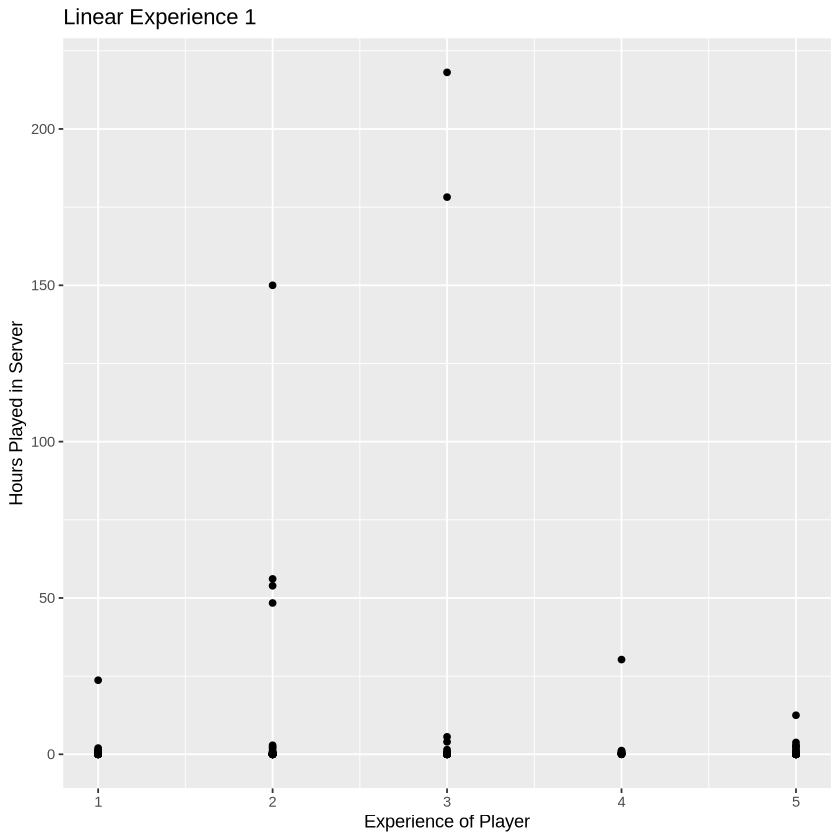

In [3]:
set.seed(411)

plotting <- ggplot(player_training, aes(x = experience_scaled, y = played_hours)) +
    geom_point() +
    labs(x = "Experience of Player", y = "Hours Played in Server", title = "Linear Experience 1")

plotting 

Did an initial plot of the training data to get an idea on how the data looks.

In [4]:
set.seed(411)

lm_spec <- linear_reg() |>
    set_engine("lm") |>
    set_mode("regression")

lm_recipe <- recipe(played_hours ~ experience_scaled, data = player_training)

lm_fit <- workflow() |>
    add_recipe(lm_recipe) |>
    add_model(lm_spec) |>
    fit(data = player_training)

lm_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
      (Intercept)  experience_scaled  
           7.7011            -0.7134  


In [5]:
set.seed(411)

training_preds <- lm_fit |>
    predict(player_training) |>
    bind_cols(player_training)

head(training_preds, n=10)

.pred,experience_scaled,experience,played_hours,name
<dbl>,<dbl>,<chr>,<dbl>,<chr>
6.274237,2,Amateur,0.0,Eli
4.133951,5,Veteran,0.0,Soren
4.133951,5,Veteran,0.0,Kazuki
5.560809,3,Regular,0.0,Juniper
6.274237,2,Amateur,0.2,Gemna
6.274237,2,Amateur,0.1,Ayman
6.274237,2,Amateur,0.0,Jia
4.133951,5,Veteran,12.5,Isidore
6.274237,2,Amateur,0.1,Anastasia


Made a linear regression model with the training data by creating a recipe, a model/spec, and workflow. Collected prediction results and used it to plot predictions of training data. 

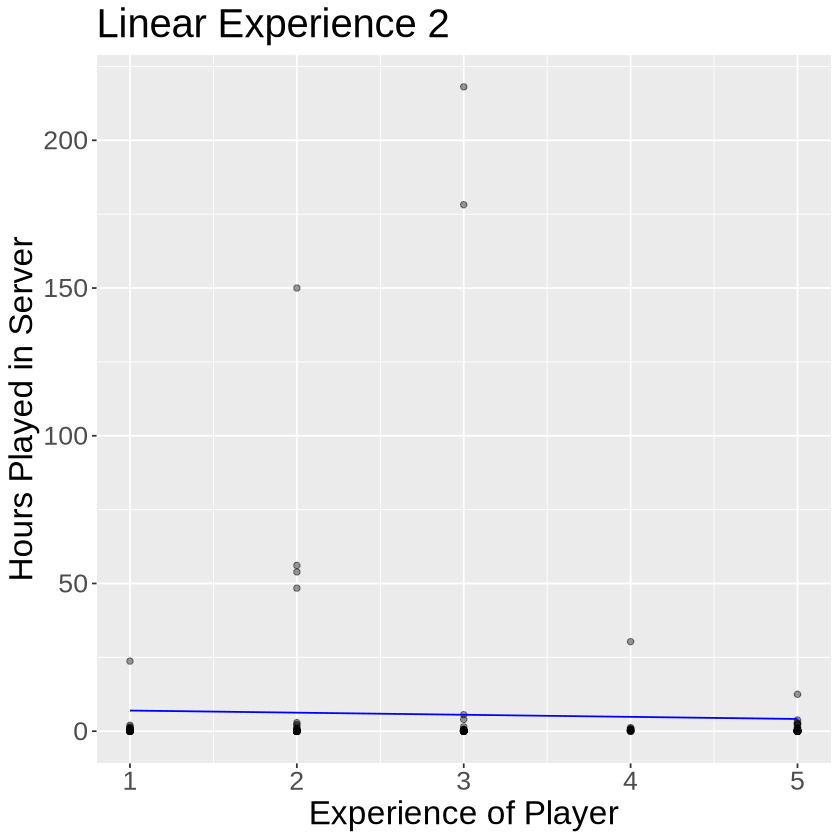

In [6]:
set.seed(411)

lm_predictions <- training_preds |>
    ggplot(aes(x = experience_scaled, y = played_hours)) +
        geom_point(alpha = 0.4) +
        geom_line(
            mapping = aes(x = experience_scaled, y = .pred), 
            color = "blue") +
        xlab("Experience of Player") +
        ylab("Hours Played in Server") +
    labs(title = "Linear Experience 2") +
        theme(text = element_text(size = 20))
lm_predictions

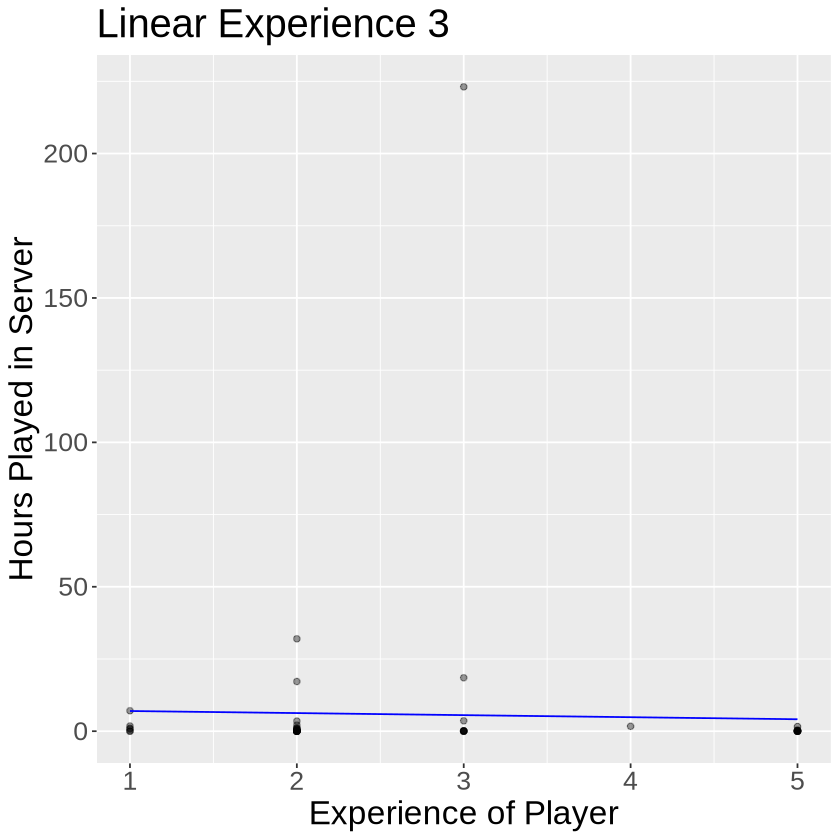

In [7]:
set.seed(411)

testing_pred <- lm_fit |>
    predict(player_testing) |>
    bind_cols(player_testing)

experience_results <- testing_pred |>
    metrics(truth = played_hours, estimate = .pred)
# experience_results

testing_predictions <- testing_pred |>
     ggplot(aes(x = experience_scaled, y = played_hours)) +
        geom_point(alpha = 0.4) +
         geom_line(data = testing_pred,
             mapping = aes(x = experience_scaled, y = .pred), 
            color = "blue") +
         xlab("Experience of Player") +
         ylab("Hours Played in Server") +
    labs(title = "Linear Experience 3") +
         theme(text = element_text(size = 20))

testing_predictions

Then predicted results with testing data and plotted it as well.

In [8]:
set.seed(411)

testing_results <- lm_fit |>
    predict(player_testing) |>
    bind_cols(player_testing) |>
    metrics(truth = played_hours, estimate = .pred) 

testing_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,3.178883e+01
rsq,standard,1.437197e-06
mae,standard,1.010228e+01


Results are inconclusive. The data is not linear enough for the model, and most of the points are at zero or near zero. There is a slight downward trend, where newer players play more, according to the predictions however it is not very accurate to the true values of the data. 

Found that the model is inconclusive with its predictions. This was pretty expected since the data had very little linear relation and many players had less than 1 played hour. There’s not a lot of impact that these findings can have because they  lead to inconclusive results that don’t help with answering what kind of player contributes the most data. 

It could lead to questions about if more data would lead to better results, or if player engagement is predictable with the variables we were provided.